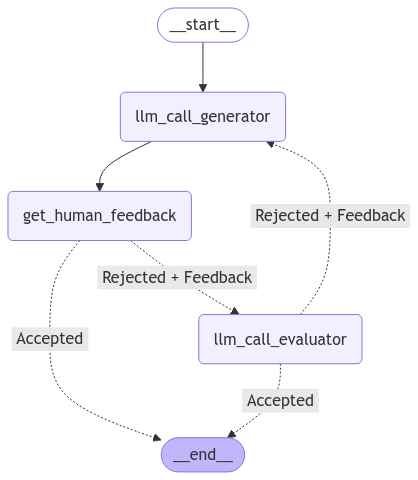

Joke: Why don't cats play poker in the wild? Because there are too many cheetahs!
Final joke that made you laugh:
Why don't cats play poker in the wild? Because there are too many cheetahs!


In [8]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict,Optional,Literal
from pydantic import BaseModel,Field
from IPython.display import display, Image
from dotenv import load_dotenv
import os

load_dotenv()

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen-2.5-32b")

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str
    human_laughed: Optional[bool]  # New field for human feedback


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


def get_human_feedback(state: State):
    """Get feedback from the human on whether they laughed"""
    
    # Display the joke to the human
    print(f"Joke: {state['joke']}")
    
    # Get human feedback
    while True:
        response = input("Did you laugh? (yes/no): ").strip().lower()
        if response in ["yes", "no"]:
            return {"human_laughed": response == "yes"}
        print("Please answer with 'yes' or 'no'.")


# Conditional edge function to route based on human feedback
def route_human_feedback(state: State):
    """Route based on human feedback"""
    
    if state["human_laughed"]:
        return "Accepted"
    else:
        return "Rejected + Feedback"


# Conditional edge function for LLM evaluation (keeping this as an alternative option)
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)
optimizer_builder.add_node("get_human_feedback", get_human_feedback)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "get_human_feedback")  # Go to human feedback first

# Add conditional edges for human feedback
optimizer_builder.add_conditional_edges(
    "get_human_feedback",
    route_human_feedback,
    {
        "Accepted": END,
        "Rejected + Feedback": "llm_call_evaluator",  # If human doesn't laugh, get LLM feedback
    },
)

# Add edges for LLM evaluation
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,  # This shouldn't happen since we already know human didn't like it
        "Rejected + Feedback": "llm_call_generator",  # Get LLM feedback and try again
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print("Final joke that made you laugh:")
print(state["joke"])